In [333]:
import numpy as np
import pandas as pd
import yaml
import torch
from torch import nn
import scanpy as sc

from celldreamer.data.scrnaseq_loader import RNAseqLoader
from celldreamer.models.featurizers.category_featurizer import CategoricalFeaturizer
from celldreamer.models.vdm.denoising_model import SimpleMLPTimeStep
from celldreamer.models.vdm.vdm import VDM
from celldreamer.eval.optimal_transport import wasserstein

from celldreamer.models.base.utils import unsqueeze_right

device  = "cuda" if torch.cuda.is_available() else "cpu"

**Util function**

In [334]:
def init_feature_embeddings(dataset, dataset_config, device):
    feature_embeddings = {}  
    num_classes = {}
            
    for cov, cov_names in dataset.id2cov.items():
        feature_embeddings["y_"+cov] = CategoricalFeaturizer(len(cov_names), 
                                                                  dataset_config["one_hot_encode_features"], 
                                                                  device, 
                                                                  embedding_dimensions=dataset_config["cov_embedding_dimensions"])
        if dataset_config["one_hot_encode_features"]:
            num_classes["y_"+cov] = len(cov_names)
        else:
            num_classes["y_"+cov] = dataset_config["cov_embedding_dimensions"]
    return feature_embeddings

**Cofigurations**

In [335]:
ckpt = torch.load("/home/icb/alessandro.palma/environment/celldreamer/project_folder/celldreamer_resnet/learnt_1.ckpt")

denoising_model = ckpt["hyper_parameters"]["denoising_model"]

In [336]:
dataset_config = {'dataset_path': '../../datasets/processed/dentategyrus.h5ad',
                    'layer_key': 'X_counts',
                    'covariate_keys': ['clusters'],
                    'sampling_covariate': 'clusters',
                    'subsample_frac': 1,
                    'use_pca': False,
                    'encoder_type': 'log_gexp',
                    'target_max': 1,
                    'target_min': -1,
                    'n_dimensions': None,
                    'one_hot_encode_features': True,
                    'split_rates': [0.90, 0.05, 0.05],
                    'cov_embedding_dimensions': None}

generative_model_config = {'learning_rate': 0.001,
                            'weight_decay': 0.00001,
                            'noise_schedule': 'fixed_linear',
                            'gamma_min': -3.,
                            'gamma_max': 4.,
                            'antithetic_time_sampling': True,
                            'scaling_method': 'log_normalization',
                            'x0_from_x_kwargs': {
                                'dims': [256, 256],
                                'batch_norm': True,
                                'dropout': False,
                                'dropout_p': 0.0
                            },
                            'pretrain_encoder': False,
                            'pretraining_encoder_epochs': 0,
                            'use_tanh_encoder': False}

**Initialization**

Initialize dataset 

In [337]:
data_path = dataset_config["dataset_path"]

dataset = RNAseqLoader(data_path=data_path,
                                layer_key=dataset_config["layer_key"],
                                covariate_keys=dataset_config["covariate_keys"],
                                subsample_frac=dataset_config["subsample_frac"], 
                                use_pca=dataset_config["use_pca"], 
                                encoder_type=dataset_config["encoder_type"],
                                target_max=dataset_config["target_max"], 
                                target_min=dataset_config["target_min"])

in_dim = dataset.X.shape[1]
size_factor_statistics = {"mean": dataset.log_size_factor_mu, 
                                  "sd": dataset.log_size_factor_sd}

/home/icb/alessandro.palma/miniconda3/envs/celldreamer/lib/python3.10/site-packages/anndata/__init__.py:51: FutureWarning: `anndata.read` is deprecated, use `anndata.read_h5ad` instead. `ad.read` will be removed in mid 2024.
  warnings.warn(


Initialize feature embeddings

In [338]:
feature_embeddings = init_feature_embeddings(dataset, dataset_config, device)

Initialize VDM 

In [339]:
generative_model = VDM(
            denoising_model=denoising_model,
            feature_embeddings=feature_embeddings,
            plotting_folder=None,
            in_dim=in_dim,
            size_factor_statistics=size_factor_statistics,
            scaler=dataset.get_scaler(),
            encoder_type=dataset_config["encoder_type"],
            sampling_covariate=dataset_config["sampling_covariate"],
            model_type=denoising_model.model_type, 
            **generative_model_config  # model_kwargs should contain the rest of the arguments
        )

generative_model.load_state_dict(ckpt["state_dict"])

/home/icb/alessandro.palma/miniconda3/envs/celldreamer/lib/python3.10/site-packages/pytorch_lightning/utilities/parsing.py:198: Attribute 'denoising_model' is an instance of `nn.Module` and is already saved during checkpointing. It is recommended to ignore them using `self.save_hyperparameters(ignore=['denoising_model'])`.


<All keys matched successfully>

In [394]:
denoising_model

MLPTimeStep(
  (net_in): Linear(in_features=2000, out_features=256, bias=True)
  (down_blocks): ModuleList(
    (0): ResnetBlock(
      (net1): Sequential(
        (0): Linear(in_features=256, out_features=128, bias=True)
        (1): SiLU()
        (2): Linear(in_features=128, out_features=128, bias=True)
      )
      (net2): Sequential(
        (0): SiLU()
        (1): Linear(in_features=129, out_features=128, bias=True)
      )
      (skip_proj): Linear(in_features=256, out_features=128, bias=True)
    )
    (1): ResnetBlock(
      (net1): Sequential(
        (0): Linear(in_features=128, out_features=64, bias=True)
        (1): SiLU()
        (2): Linear(in_features=64, out_features=64, bias=True)
      )
      (net2): Sequential(
        (0): SiLU()
        (1): Linear(in_features=65, out_features=64, bias=True)
      )
      (skip_proj): Linear(in_features=128, out_features=64, bias=True)
    )
  )
  (up_blocks): ModuleList(
    (0): ResnetBlock(
      (net1): Sequential(
       

**Check the data**

In [341]:
adata_original = sc.read_h5ad(data_path)
adata_original.obs["size_factor"]=adata_original.X.A.sum(1)

In [342]:
X = torch.tensor(adata_original.layers["X_counts"].todense())

In [343]:
# wasserstein(X_1, X_2)

More or less the range for the Wasserstein distance must be 100-200

**Collect checkpoints and run**

In [380]:
X_generated = generative_model.sample(batch_size=10000, 
                                     n_sample_steps=1000, 
                                     clip_samples=False,
                                     covariate="clusters")

sampling: 100%|██████████| 1000/1000 [04:51<00:00,  3.43it/s]


Analyze the results

In [381]:
# size_factor

In [382]:
X_generated.sum(1)

tensor([  2301., 113549., 364212.,  ...,   1456.,   1807.,  10394.])

In [383]:
for i in X_generated[0]:
    print(i)

tensor(0.)
tensor(0.)
tensor(0.)
tensor(0.)
tensor(0.)
tensor(1.)
tensor(0.)
tensor(0.)
tensor(0.)
tensor(0.)
tensor(0.)
tensor(0.)
tensor(0.)
tensor(0.)
tensor(0.)
tensor(8.)
tensor(0.)
tensor(0.)
tensor(0.)
tensor(0.)
tensor(0.)
tensor(0.)
tensor(0.)
tensor(0.)
tensor(0.)
tensor(0.)
tensor(0.)
tensor(0.)
tensor(10.)
tensor(0.)
tensor(0.)
tensor(0.)
tensor(0.)
tensor(1.)
tensor(0.)
tensor(0.)
tensor(0.)
tensor(0.)
tensor(0.)
tensor(0.)
tensor(0.)
tensor(0.)
tensor(0.)
tensor(0.)
tensor(0.)
tensor(0.)
tensor(0.)
tensor(5.)
tensor(0.)
tensor(0.)
tensor(0.)
tensor(0.)
tensor(0.)
tensor(0.)
tensor(0.)
tensor(0.)
tensor(0.)
tensor(0.)
tensor(0.)
tensor(0.)
tensor(0.)
tensor(0.)
tensor(0.)
tensor(0.)
tensor(0.)
tensor(1.)
tensor(0.)
tensor(0.)
tensor(0.)
tensor(0.)
tensor(0.)
tensor(0.)
tensor(2.)
tensor(0.)
tensor(0.)
tensor(0.)
tensor(0.)
tensor(0.)
tensor(0.)
tensor(0.)
tensor(0.)
tensor(0.)
tensor(0.)
tensor(0.)
tensor(0.)
tensor(0.)
tensor(0.)
tensor(0.)
tensor(0.)
tensor(0.)
tensor(0.

Create adata and check plots

In [384]:
adata = sc.AnnData(X=X_generated.cpu().numpy())

In [385]:
sc.pp.log1p(adata)
sc.tl.pca(adata)
sc.pp.neighbors(adata)
sc.tl.umap(adata)

In [386]:
adata.obs["size_factor"] = adata.X.sum(1)

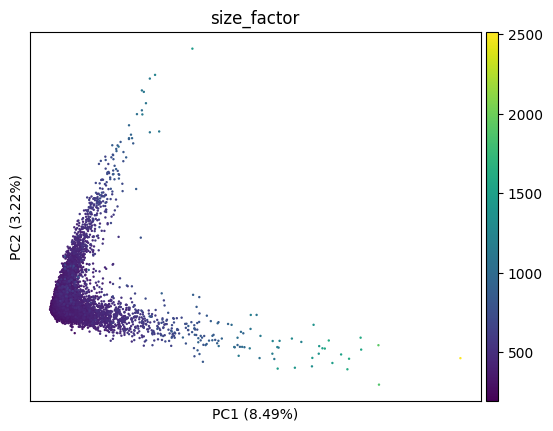

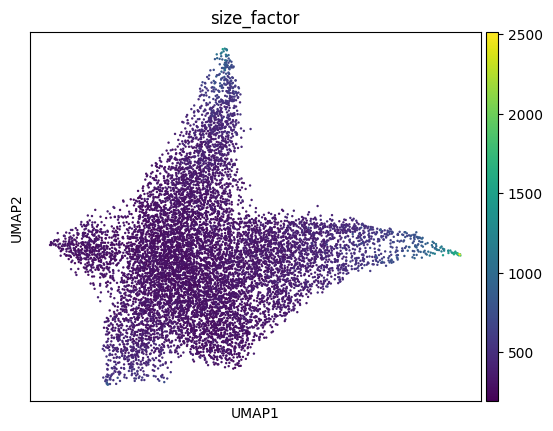

In [387]:
sc.pl.pca(adata, color="size_factor", annotate_var_explained=True)
sc.pl.umap(adata, color="size_factor")

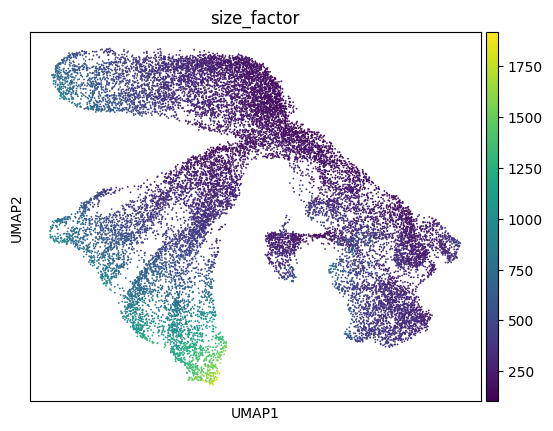

In [388]:
sc.pl.umap(adata_original, color="size_factor")

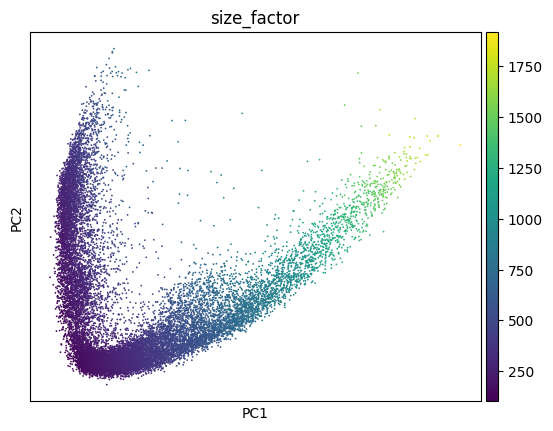

In [393]:
sc.pl.pca(adata_original, color="size_factor")

In [390]:
for i in generative_model.theta:
    print(i)

tensor(-6.2188, grad_fn=<UnbindBackward0>)
tensor(-3.4197, grad_fn=<UnbindBackward0>)
tensor(-3.1839, grad_fn=<UnbindBackward0>)
tensor(-1.8837, grad_fn=<UnbindBackward0>)
tensor(-0.5443, grad_fn=<UnbindBackward0>)
tensor(-0.7015, grad_fn=<UnbindBackward0>)
tensor(-9.2355, grad_fn=<UnbindBackward0>)
tensor(-2.9204, grad_fn=<UnbindBackward0>)
tensor(-0.8619, grad_fn=<UnbindBackward0>)
tensor(-1.5938, grad_fn=<UnbindBackward0>)
tensor(0.0247, grad_fn=<UnbindBackward0>)
tensor(-1.8666, grad_fn=<UnbindBackward0>)
tensor(-1.6502, grad_fn=<UnbindBackward0>)
tensor(-1.6861, grad_fn=<UnbindBackward0>)
tensor(-5.4467, grad_fn=<UnbindBackward0>)
tensor(0.5328, grad_fn=<UnbindBackward0>)
tensor(0.4357, grad_fn=<UnbindBackward0>)
tensor(-2.3648, grad_fn=<UnbindBackward0>)
tensor(-5.2720, grad_fn=<UnbindBackward0>)
tensor(-4.3403, grad_fn=<UnbindBackward0>)
tensor(-1.3901, grad_fn=<UnbindBackward0>)
tensor(-2.2368, grad_fn=<UnbindBackward0>)
tensor(-1.8817, grad_fn=<UnbindBackward0>)
tensor(-1.7077

In [391]:
adata_original.X.sum(1)

matrix([[467.92618],
        [455.06387],
        [875.6751 ],
        ...,
        [274.8106 ],
        [251.62425],
        [220.27817]], dtype=float32)

In [392]:
adata_original.layers["X_counts"].A.sum(1).max()

11976.0